1. Prerequisites

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import glob
import zipfile
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install kaggle

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2. Importing the dataset

In [5]:
print('Current working directory:', os.getcwd())
print('\nFiles in current directory:')
for f in os.listdir('.'):
    print(' -', f)

# If any .zip files exist, show the first few entries
zips = glob.glob('*.zip')
if zips:
    print('\nFound zip files:')
    for z in zips:
        print(' -', z)
        try:
            with zipfile.ZipFile(z) as zf:
                print('   zip contents (first 20):', zf.namelist()[:20])
        except Exception as e:
            print('   failed to read zip:', e)

# Try to locate a likely CSV and read it
candidates = ['metadata.csv', 'pokemon.csv']
found = False
for name in candidates:
    if os.path.exists(name):
        print(f"\nLoading {name} with pandas...")
        df = pd.read_csv(name)
        print(df.head())
        print('\nInfo:')
        print(df.info())
        found = True
        break

# If not in current dir, walk subfolders and try to find the CSV
if not found:
    for root, dirs, files in os.walk('.'):
        for f in files:
            if f in candidates:
                path = os.path.join(root, f)
                print(f"\nFound {f} at {path}, loading...")
                df = pd.read_csv(path)
                print(df.head())
                print('\nInfo:')
                print(df.info())
                found = True
                break
        if found:
            break

if not found:
    print('\nNo candidate CSV found. If download produced a zip, unzip it or check subfolders.')
    print('If using kaggle CLI, consider using kaggle.api.dataset_download_files("noodulz/pokemon-dataset-1000", unzip=True)')

Current working directory: /Users/isaaclau128/Downloads/Pokedex Project

Files in current directory:
 - pokemon-dataset-1000
 - Pokedex.ipynb
 - Pokedex.ipynb.bak

Found metadata.csv at ./pokemon-dataset-1000/metadata.csv, loading...
       label                          image_path  hp  attack  defense  \
0  abomasnow   dataset/abomasnow/abomasnow_8.png  90      92       75   
1  abomasnow  dataset/abomasnow/abomasnow_18.png  90      92       75   
2  abomasnow  dataset/abomasnow/abomasnow_11.png  90      92       75   
3  abomasnow  dataset/abomasnow/abomasnow_16.png  90      92       75   
4  abomasnow   dataset/abomasnow/abomasnow_9.png  90      92       75   

   special-attack  special-defense  speed  
0              92               85     60  
1              92               85     60  
2              92               85     60  
3              92               85     60  
4              92               85     60  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26539 

In [6]:
file_path = './pokemon-dataset-1000/metadata.csv'


if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("File loaded successfully.")
    print("\nFirst 5 rows of the DataFrame:")
    display(df.head())
    print("\nInfo of the DataFrame:")
    display(df.info())
else:
    print(f"File not found at {file_path}. Please ensure the file is in the correct directory.")

File loaded successfully.

First 5 rows of the DataFrame:


label                          image_path  hp  attack  defense  \
0  abomasnow   dataset/abomasnow/abomasnow_8.png  90      92       75   
1  abomasnow  dataset/abomasnow/abomasnow_18.png  90      92       75   
2  abomasnow  dataset/abomasnow/abomasnow_11.png  90      92       75   
3  abomasnow  dataset/abomasnow/abomasnow_16.png  90      92       75   
4  abomasnow   dataset/abomasnow/abomasnow_9.png  90      92       75   

   special-attack  special-defense  speed  
0              92               85     60  
1              92               85     60  
2              92               85     60  
3              92               85     60  
4              92               85     60


Info of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26539 entries, 0 to 26538
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   label            26539 non-null  object
 1   image_path       26539 non-null  object
 2   hp               26539 non-null  int64 
 3   attack           26539 non-null  int64 
 4   defense          26539 non-null  int64 
 5   special-attack   26539 non-null  int64 
 6   special-defense  26539 non-null  int64 
 7   speed            26539 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.6+ MB


None

In [7]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


IMG_SIZE = 128
BATCH_SIZE = 64  # Batch size
LEARNING_RATE = 0.001  # Learning rate
NUM_EPOCHS = 10  # Number of training epochs
NUM_CLASSES = 1000  # Number of clothing categories

3. Splitting into testing and training data sets

In [8]:
from sklearn.model_selection import train_test_split

# Split the dataframe into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['label'])

print(f"Training data size: {len(train_df)}")
print(f"Testing data size: {len(test_df)}")

Training data size: 21231
Testing data size: 5308


4. Data Preprocessing

In [9]:
# Set image_base_dir to the parent folder that contains the 'dataset' folder referenced in metadata.csv
# In the metadata the image_path values include a leading 'dataset/...' segment,
# so the correct base is the dataset root (not the nested 'dataset' folder).
image_base_dir = './pokemon-dataset-1000'

# Verify the base exists
if not os.path.exists(image_base_dir):
    raise FileNotFoundError(f"image_base_dir does not exist: {image_base_dir}")

# Create a custom dataset class
class PokemonDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        # Ensure label column exists
        if 'label' not in self.dataframe.columns:
            raise KeyError("Expected 'label' column in metadata.csv")
        # Ensure image_path column exists (common name in this dataset)
        if 'image_path' not in self.dataframe.columns:
            raise KeyError("Expected 'image_path' column in metadata.csv")

        self.classes = sorted(self.dataframe['label'].unique())
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Use named columns for clarity
        rel_path = str(self.dataframe.loc[idx, 'image_path'])
        # Build full path (rel_path usually contains 'dataset/...' in this CSV)
        img_path = os.path.join(self.img_dir, rel_path)

        if not os.path.exists(img_path):
            # Provide helpful debug info
            raise FileNotFoundError(f"Image not found: {img_path}")

        image = Image.open(img_path).convert('RGB')

        label_name = self.dataframe.loc[idx, 'label']
        label = self.class_to_idx[label_name]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations (you might need to adjust these based on your model)
# Example transformations for image data
pokemon_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # Resize images to a fixed size
    transforms.ToTensor(), # Convert PIL Image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet standards
])

# Create train/test datasets and loaders if train_df/test_df are available
try:
    # train_df and test_df are created earlier by train_test_split
    train_dataset = PokemonDataset(dataframe=train_df, img_dir=image_base_dir, transform=pokemon_transform)
    test_dataset = PokemonDataset(dataframe=test_df, img_dir=image_base_dir, transform=pokemon_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Backwards compatible name
    pokemon_loader = train_loader
    pokemon_class_names = train_dataset.classes

    print(f'Created train_loader ({len(train_dataset)} samples) and test_loader ({len(test_dataset)} samples)')
except NameError:
    # Fallback: if train_df/test_df are not defined, use the full dataframe 'df'
    pokemon_dataset = PokemonDataset(dataframe=df, img_dir=image_base_dir, transform=pokemon_transform)
    pokemon_loader = DataLoader(pokemon_dataset, batch_size=BATCH_SIZE, shuffle=True)
    train_loader = pokemon_loader
    test_loader = pokemon_loader
    pokemon_class_names = pokemon_dataset.classes
    print('train_df/test_df not found; using full dataset for both train and test (pokemon_loader)')

# Print dataset size and class names
print(f'Pokemon dataset sample count (train): {len(train_loader.dataset)}')
print(f'Pokemon class names ({len(pokemon_class_names)}): {pokemon_class_names}')

# Visualize a batch of training images with their labels
def visualize_pokemon_batch(loader, class_names):
    images, labels = next(iter(loader))
    # Move to CPU (if on GPU) and convert to numpy for matplotlib
    if hasattr(images, 'cpu'):
        images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    else:
        images_np = images.permute(0, 2, 3, 1).numpy()

    labels_np = labels.cpu().numpy() if hasattr(labels, 'cpu') else labels.numpy()

    plt.figure(figsize=(12, 6))
    for i in range(min(len(images_np), 8)): # Visualize up to 8 images
        ax = plt.subplot(2, 4, i + 1)
        # Denormalize and clip for display
        img = images_np[i] * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(class_names[int(labels_np[i])])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_pokemon_batch(pokemon_loader, pokemon_class_names)


Created train_loader (21231 samples) and test_loader (5308 samples)
Pokemon dataset sample count (train): 21231
Pokemon class names (1000): ['abomasnow', 'abra', 'absol', 'accelgor', 'aegislash-shield', 'aerodactyl', 'aggron', 'aipom', 'alakazam', 'alcremie', 'alomomola', 'altaria', 'amaura', 'ambipom', 'amoonguss', 'ampharos', 'annihilape', 'anorith', 'appletun', 'applin', 'araquanid', 'arbok', 'arboliva', 'arcanine', 'arceus', 'archen', 'archeops', 'arctibax', 'arctovish', 'arctozolt', 'ariados', 'armaldo', 'armarouge', 'aromatisse', 'aron', 'arrokuda', 'articuno', 'audino', 'aurorus', 'avalugg', 'axew', 'azelf', 'azumarill', 'azurill', 'bagon', 'baltoy', 'banette', 'barbaracle', 'barboach', 'barraskewda', 'basculegion-male', 'basculin-red-striped', 'bastiodon', 'baxcalibur', 'bayleef', 'beartic', 'beautifly', 'beedrill', 'beheeyem', 'beldum', 'bellibolt', 'bellossom', 'bellsprout', 'bergmite', 'bewear', 'bibarel', 'bidoof', 'binacle', 'bisharp', 'blacephalon', 'blastoise', 'blaziken

5. Model Architecture

In [10]:
# TODO: Create a classifier class inheriting from nn.Module

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()

        # Convolutional layers: Adjusted input channels to 3 for RGB images
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # The flattened size calculation depends on the input image size and pooling.
        # For 128x128 images and two max pooling layers with kernel_size=2 and stride=2,
        # the size after pooling will be 128/2/2 = 32.
        # So the flattened size will be 128 * 32 * 32
        self.fc1 = nn.Linear(128 * (IMG_SIZE // 4) * (IMG_SIZE // 4), 256) # Adjusted input size calculation
        self.fc2 = nn.Linear(256, NUM_CLASSES)                             # Output layer: Adjusted to NUM_CLASSES
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        # print(f"Shape after conv1 and pool: {x.shape}") # Optional: uncomment for debugging
        x = self.pool(self.relu(self.conv2(x)))
        # print(f"Shape after conv2 and pool: {x.shape}") # Optional: uncomment for debugging
        # NOTE: conv2 produces 128 output channels, so the flattened size must use 128
        x = x.view(-1, 128 * (IMG_SIZE // 4) * (IMG_SIZE // 4))  # Flatten: match fc1 in_features
        # print(f"Shape after flattening: {x.shape}") # Optional: uncomment for debugging
        x = self.dropout(self.relu(self.fc1(x)))
        # print(f"Shape after fc1 and dropout: {x.shape}") # Optional: uncomment for debugging
        x = self.fc2(x)
        # print(f"Shape after fc2: {x.shape}") # Optional: uncomment for debugging
        return x

# Determine the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CNNClassifier().to(device)

# TODO: Implement forward(self, x) method (Already done above)
# TODO: Initialize model and move to device (Already done above)
# TODO: Print model architecture and parameter count
# TODO: Test with random input to verify output shape


Using device: cpu


6. Loss Function

In [11]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Ensure NUM_CLASSES matches the dataset if available
try:
    NUM_CLASSES = len(pokemon_class_names)
    print(f"Setting NUM_CLASSES to {NUM_CLASSES} based on dataset classes")
except NameError:
    print('pokemon_class_names not found; using existing NUM_CLASSES value')

# Create model and move to device
model = CNNClassifier().to(device)

LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#       or torch.optim.SGD with momentum

# Define loss function (again, safe to reassign)
criterion = nn.CrossEntropyLoss()

Setting NUM_CLASSES to 1000 based on dataset classes


7. Training Function

In [12]:
# TODO: Create training function:
def train_model(model, train_loader, criterion, optimizer, num_epochs=NUM_EPOCHS, device=device, test_loader=None):
    # TODO: Initialize lists to store losses and accuracies
    train_losses = []
    train_accuracies = []
    test_losses = [] # Added list to store test losses per epoch
    test_accuracies = [] # Added list to store test accuracies per epoch

    # TODO: For each epoch:
    for epoch in range(num_epochs):
        #       - Set model to training mode
        model.train()
        #       - Initialize running loss and correct predictions
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        #       For each batch:
        for i, (images, labels) in enumerate(train_loader): # Added enumerate to track batch index
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            #       - Zero gradients
            optimizer.zero_grad()
            #       - Forward pass: outputs = model(images)
            outputs = model(images)

            #       - Calculate loss: loss = criterion(outputs, labels)
            loss = criterion(outputs, labels)
            #       - Backward pass: loss.backward()
            loss.backward()
            #       - Update weights: optimizer.step()
            optimizer.step()

            #       - Track statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()


        # TODO: Calculate and print epoch statistics (loss, accuracy)
        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Evaluate on test set after each epoch if provided
        if test_loader is not None:
            test_loss, test_accuracy = evaluate_model(model, test_loader, criterion, device) # Use the existing evaluate_model function
        else:
            test_loss, test_accuracy = float('nan'), float('nan')

        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)


        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

        # TODO: Optional: Update learning rate with scheduler

# TODO: Print progress
    # if (epoch + 1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    print("\nTraining finished.") # This line should be outside the epoch loop


    # TODO: Return training history for plotting
    return train_losses, train_accuracies, test_losses, test_accuracies # Return test losses and accuracies


Starting evaluation...
Test Loss: 6.9132, Test Accuracy: 0.0008

Classification Report:
                            precision    recall  f1-score   support

                 abomasnow       0.00      0.00      0.00        32
                      abra       0.00      0.00      0.00        32
                     absol       0.00      0.00      0.00        30
                  accelgor       0.00      0.00      0.00        16
          aegislash-shield       0.00      0.00      0.00        13
                aerodactyl       0.00      0.00      0.00        32
                    aggron       0.00      0.00      0.00        30
                     aipom       0.00      0.00      0.00        32
                  alakazam       0.00      0.00      0.00        32
                  alcremie       0.00      0.00      0.00        10
                 alomomola       0.00      0.00      0.00        16
                   altaria       0.00      0.00      0.00        30
                    amaura

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

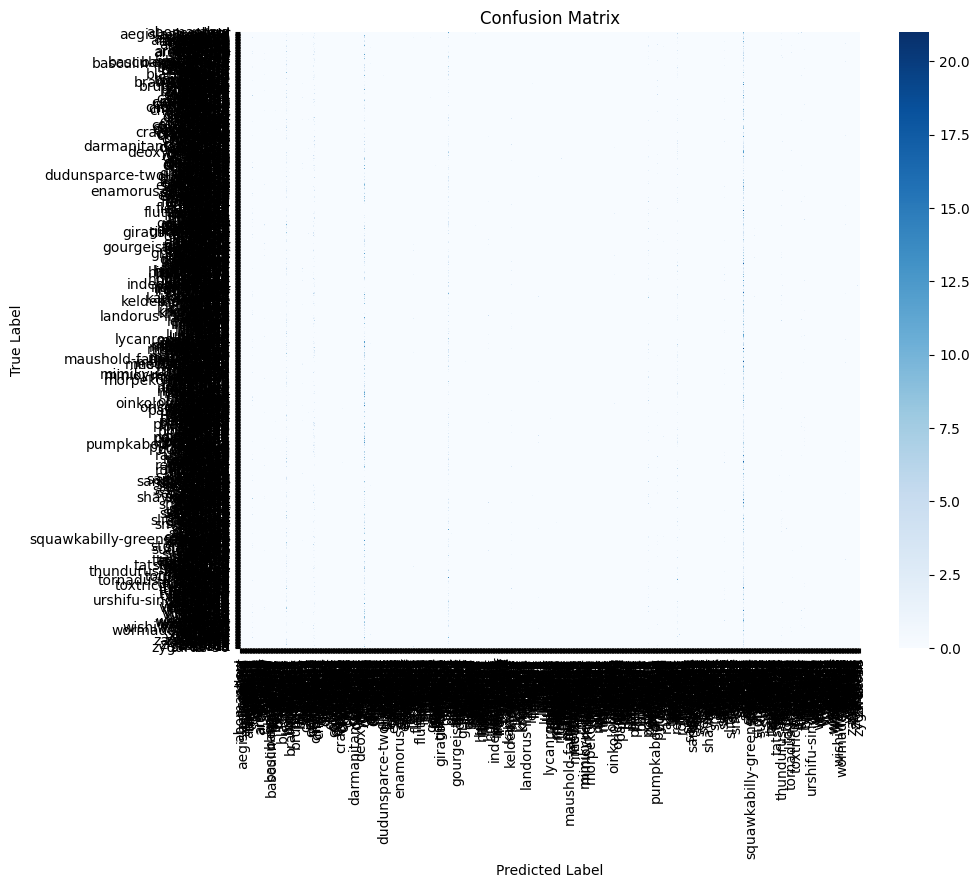

abomasnow: 0.0000
abra: 0.0000
absol: 0.0000
accelgor: 0.0000
aegislash-shield: 0.0000
aerodactyl: 0.0000
aggron: 0.0000
aipom: 0.0000
alakazam: 0.0000
alcremie: 0.0000
alomomola: 0.0000
altaria: 0.0000
amaura: 0.0000
ambipom: 0.0000
amoonguss: 0.0000
ampharos: 0.0000
annihilape: 0.0000
anorith: 0.0000
appletun: 0.0000
applin: 0.0000
araquanid: 0.0000
arbok: 0.0000
arboliva: 0.0000
arcanine: 0.0000
arceus: 0.0000
archen: 0.0000
archeops: 0.0000
arctibax: 0.0000
arctovish: 0.0000
arctozolt: 0.0000
ariados: 0.0000
armaldo: 0.0000
armarouge: 0.0000
aromatisse: 0.0000
aron: 0.0000
arrokuda: 0.0000
articuno: 0.0000
audino: 0.0000
aurorus: 0.0000
avalugg: 0.0000
axew: 0.0000
azelf: 0.0000
azumarill: 0.0000
azurill: 0.0000
bagon: 0.0000
baltoy: 0.0000
banette: 0.0000
barbaracle: 0.0000
barboach: 0.0000
barraskewda: 0.0000
basculegion-male: 0.0000
basculin-red-striped: 0.0000
bastiodon: 0.0000
baxcalibur: 0.0000
bayleef: 0.0000
beartic: 0.0000
beautifly: 0.0000
beedrill: 0.0000
beheeyem: 0.000

In [13]:
# Evaluation function (robust and fixed syntax)
def evaluate_model(model, test_loader, criterion, device, class_names=None):
    """Evaluate model on test_loader.

    If class_names is None, the function will attempt to derive class names from
    test_loader.dataset.classes or test_loader.dataset.class_to_idx.
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)

            running_loss += loss.item() * images.size(0)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    if total_samples == 0:
        print("No samples found in test_loader. Cannot evaluate.")
        return float('nan'), float('nan')

    # Calculate overall test accuracy and loss
    test_loss = running_loss / total_samples
    test_accuracy = correct_predictions / total_samples
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # If class_names not provided, try to derive from dataset
    if class_names is None:
        try:
            dataset = test_loader.dataset
            if hasattr(dataset, 'classes'):
                class_names = dataset.classes
            elif hasattr(dataset, 'class_to_idx'):
                # class_to_idx is a dict name->index; sort by index
                inv = sorted(dataset.class_to_idx.items(), key=lambda x: x[1])
                class_names = [n for n, _ in inv]
            else:
                class_names = None
        except Exception:
            class_names = None

    # Classification report
    try:
        print('\nClassification Report:')
        if class_names is None:
            print(classification_report(all_labels, all_predictions))
        else:
            print(classification_report(all_labels, all_predictions, target_names=class_names))
    except Exception as e:
        print('Failed to generate classification report:', e)

    # Confusion matrix (be careful with very large number of classes)
    try:
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        xt = class_names if class_names is not None else None
        yt = class_names if class_names is not None else None
        sns.heatmap(cm, annot=False if cm.size > 10000 else True, fmt='d', cmap='Blues', xticklabels=xt, yticklabels=yt)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        print('Failed to plot confusion matrix:', e)

    # Per-class accuracies
    try:
        if class_names is None:
            classes_iter = sorted(set(all_labels))
            names_iter = [str(c) for c in classes_iter]
        else:
            classes_iter = range(len(class_names))
            names_iter = class_names

        for i, cls_name in zip(classes_iter, names_iter):
            class_correct = np.sum((np.array(all_predictions) == i) & (np.array(all_labels) == i))
            class_total = np.sum(np.array(all_labels) == i)
            accuracy = class_correct / class_total if class_total > 0 else 0
            print(f'{cls_name}: {accuracy:.4f}')
    except Exception as e:
        print('Failed computing per-class accuracies:', e)

    return test_loss, test_accuracy


# Execute Evaluation
print("\nStarting evaluation...")
# Need to create a test_loader specifically for the Pokemon dataset
# Using the same pokemon_loader for now, but ideally would have a separate test_loader
try:
    class_param = pokemon_class_names
except NameError:
    class_param = None

test_loss, test_accuracy = evaluate_model(model, pokemon_loader, criterion, device, class_param) # Pass pokemon_class_names if available
print("Evaluation complete!")


Starting training...
Test Loss: 5.5684, Test Accuracy: 0.1594

Classification Report:
                            precision    recall  f1-score   support

                 abomasnow       0.24      0.88      0.38         8
                      abra       1.00      0.12      0.22         8
                     absol       0.33      0.12      0.18         8
                  accelgor       0.00      0.00      0.00         4
          aegislash-shield       0.00      0.00      0.00         3
                aerodactyl       0.33      0.12      0.18         8
                    aggron       0.14      0.62      0.23         8
                     aipom       0.00      0.00      0.00         8
                  alakazam       0.67      0.25      0.36         8
                  alcremie       0.00      0.00      0.00         3
                 alomomola       0.00      0.00      0.00         4
                   altaria       0.13      0.38      0.19         8
                    amaura  

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

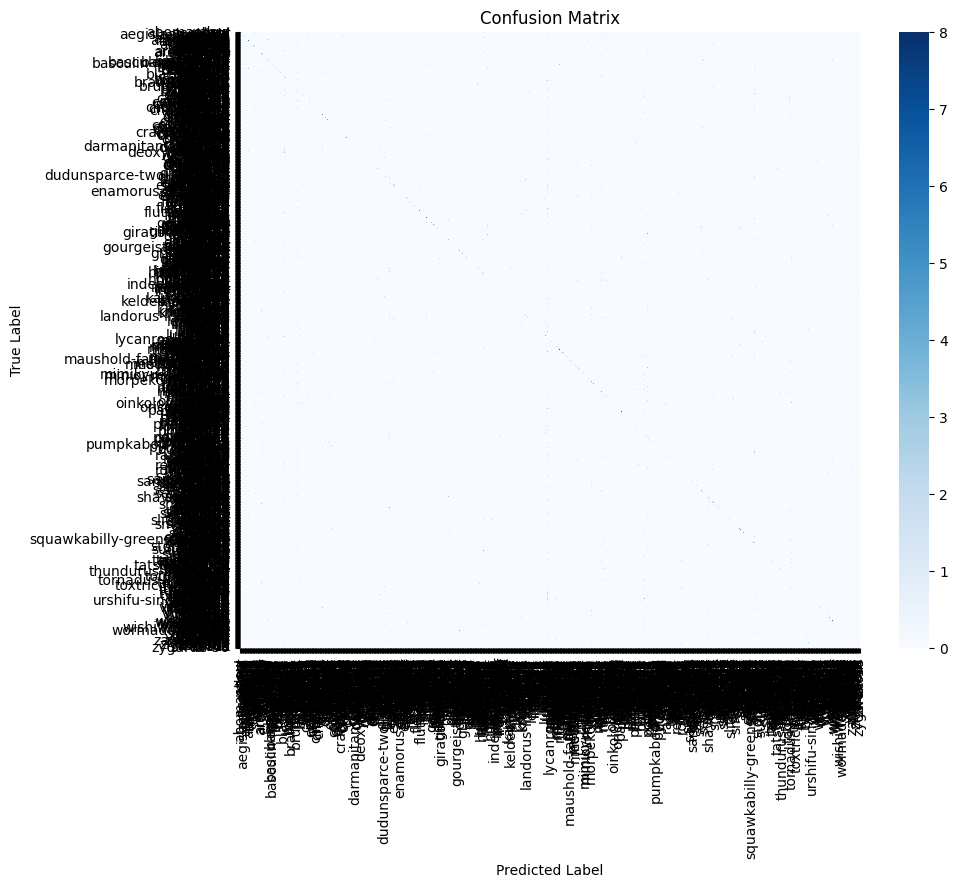

abomasnow: 0.8750
abra: 0.1250
absol: 0.1250
accelgor: 0.0000
aegislash-shield: 0.0000
aerodactyl: 0.1250
aggron: 0.6250
aipom: 0.0000
alakazam: 0.2500
alcremie: 0.0000
alomomola: 0.0000
altaria: 0.3750
amaura: 0.0000
ambipom: 0.7500
amoonguss: 0.0000
ampharos: 0.0000
annihilape: 0.0000
anorith: 0.1250
appletun: 0.0000
applin: 0.0000
araquanid: 0.0000
arbok: 0.2500
arboliva: 0.0000
arcanine: 0.2500
arceus: 0.1667
archen: 0.0000
archeops: 0.0000
arctibax: 0.0000
arctovish: 0.0000
arctozolt: 0.0000
ariados: 0.5000
armaldo: 0.0000
armarouge: 0.0000
aromatisse: 0.0000
aron: 0.5000
arrokuda: 0.0000
articuno: 0.2500
audino: 0.0000
aurorus: 0.0000
avalugg: 0.0000
axew: 0.0000
azelf: 0.0000
azumarill: 0.1250
azurill: 0.0000
bagon: 0.2500
baltoy: 0.0000
banette: 0.1250
barbaracle: 0.0000
barboach: 0.0000
barraskewda: 0.0000
basculegion-male: 0.0000
basculin-red-striped: 0.0000
bastiodon: 0.3333
baxcalibur: 0.0000
bayleef: 0.0000
beartic: 0.2500
beautifly: 0.2500
beedrill: 0.0000
beheeyem: 0.000

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

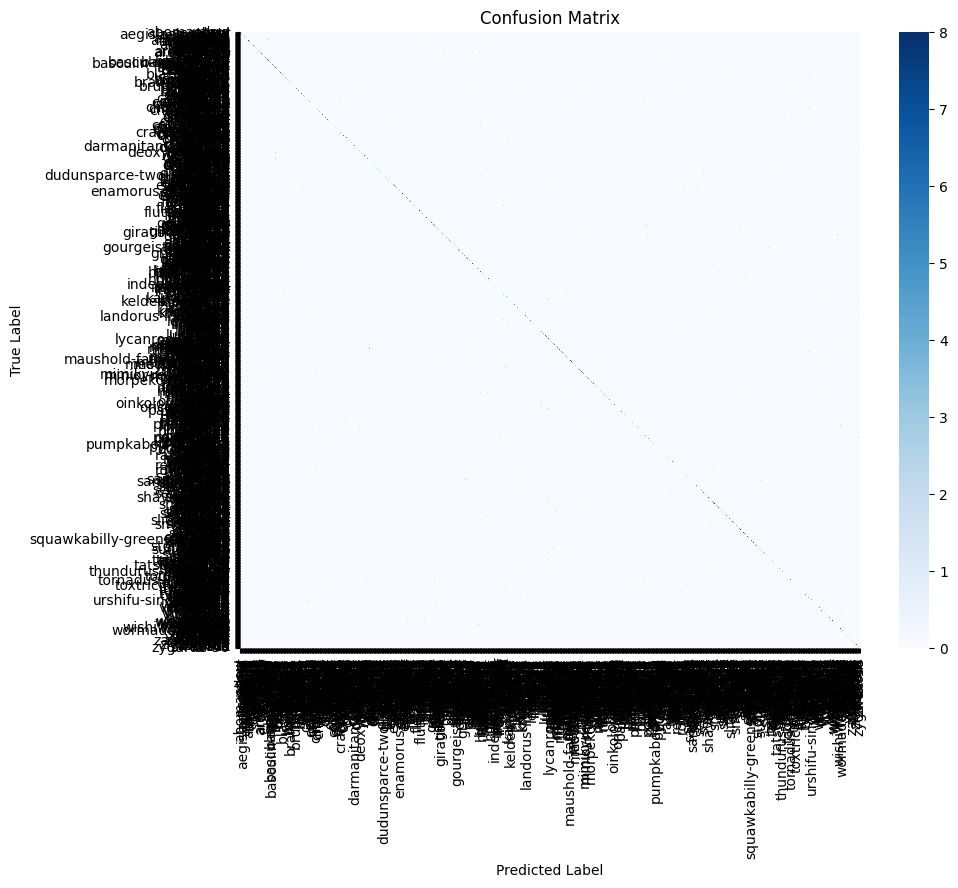

abomasnow: 0.8750
abra: 0.5000
absol: 0.5000
accelgor: 0.2500
aegislash-shield: 0.6667
aerodactyl: 0.1250
aggron: 0.8750
aipom: 0.5000
alakazam: 0.5000
alcremie: 0.0000
alomomola: 0.5000
altaria: 0.5000
amaura: 0.0000
ambipom: 1.0000
amoonguss: 0.5000
ampharos: 0.5000
annihilape: 0.0000
anorith: 0.5000
appletun: 0.3333
applin: 0.0000
araquanid: 0.0000
arbok: 0.6250
arboliva: 0.0000
arcanine: 0.3750
arceus: 0.5000
archen: 0.0000
archeops: 0.2500
arctibax: 0.0000
arctovish: 0.0000
arctozolt: 0.3333
ariados: 0.2500
armaldo: 0.3750
armarouge: 0.0000
aromatisse: 0.0000
aron: 0.7500
arrokuda: 0.3333
articuno: 0.2500
audino: 0.2500
aurorus: 0.0000
avalugg: 0.3333
axew: 0.0000
azelf: 0.8333
azumarill: 0.3750
azurill: 0.0000
bagon: 0.7500
baltoy: 0.7500
banette: 0.7500
barbaracle: 0.6667
barboach: 0.2500
barraskewda: 1.0000
basculegion-male: 0.0000
basculin-red-striped: 0.7500
bastiodon: 0.8333
baxcalibur: 0.0000
bayleef: 0.3750
beartic: 0.7500
beautifly: 0.7500
beedrill: 0.8750
beheeyem: 0.750

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

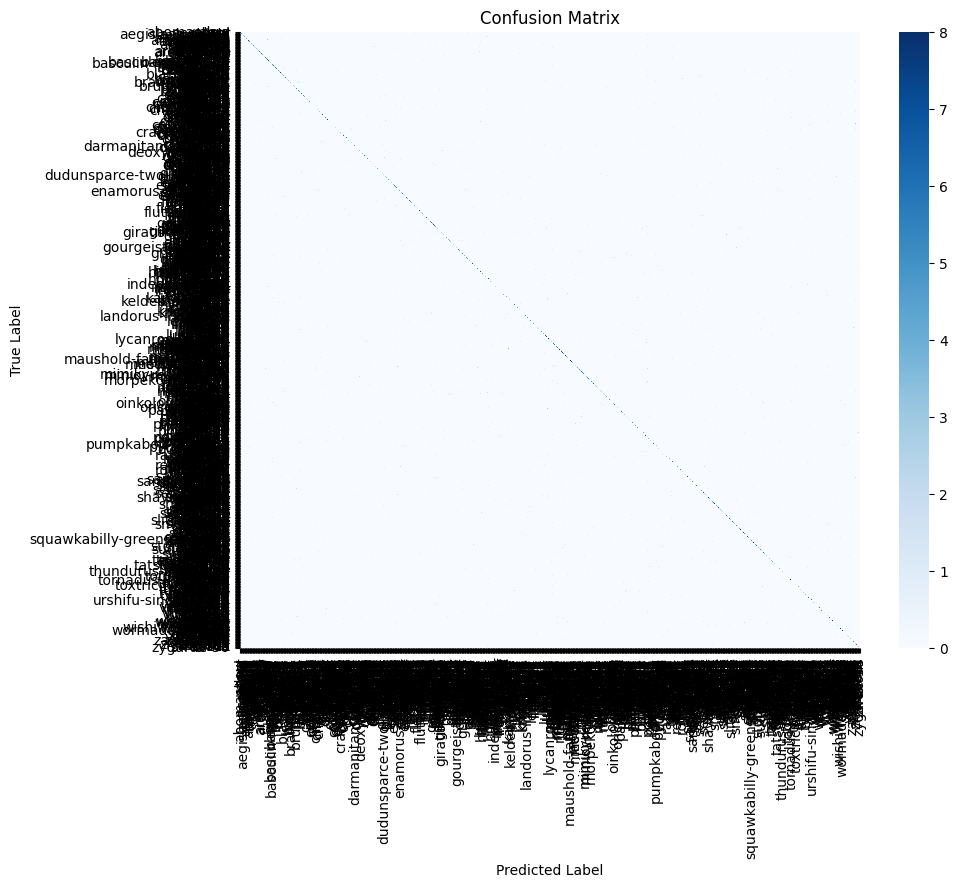

abomasnow: 0.8750
abra: 0.6250
absol: 0.6250
accelgor: 0.7500
aegislash-shield: 0.6667
aerodactyl: 0.3750
aggron: 0.8750
aipom: 0.5000
alakazam: 0.8750
alcremie: 0.6667
alomomola: 0.7500
altaria: 0.6250
amaura: 0.0000
ambipom: 1.0000
amoonguss: 0.7500
ampharos: 0.6250
annihilape: 0.0000
anorith: 0.7500
appletun: 1.0000
applin: 0.6667
araquanid: 0.3333
arbok: 0.6250
arboliva: 0.0000
arcanine: 0.2500
arceus: 0.6667
archen: 0.5000
archeops: 0.7500
arctibax: 0.0000
arctovish: 0.6667
arctozolt: 1.0000
ariados: 0.3750
armaldo: 0.7500
armarouge: 0.0000
aromatisse: 0.7500
aron: 0.7500
arrokuda: 0.3333
articuno: 0.5000
audino: 0.7500
aurorus: 0.3333
avalugg: 0.3333
axew: 0.5000
azelf: 0.8333
azumarill: 0.6250
azurill: 0.5000
bagon: 0.7500
baltoy: 0.8750
banette: 0.8750
barbaracle: 0.6667
barboach: 0.8750
barraskewda: 1.0000
basculegion-male: 0.0000
basculin-red-striped: 0.7500
bastiodon: 0.8333
baxcalibur: 0.0000
bayleef: 0.7500
beartic: 0.7500
beautifly: 1.0000
beedrill: 0.6250
beheeyem: 0.750

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

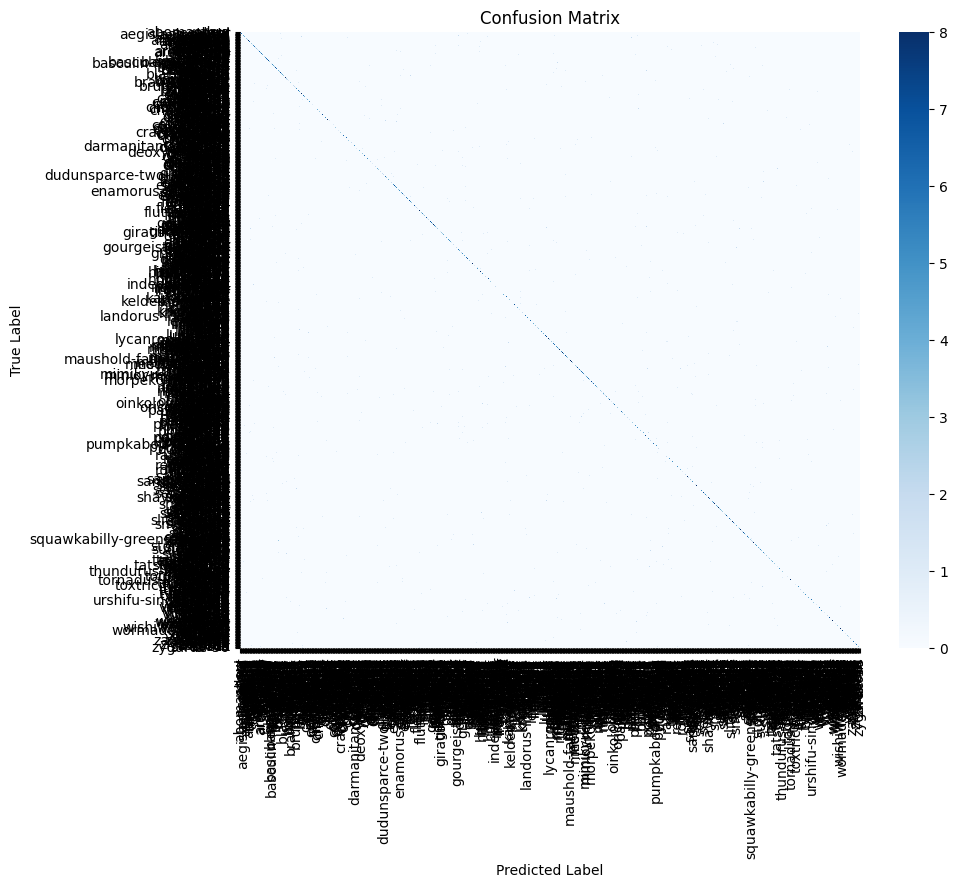

abomasnow: 1.0000
abra: 0.8750
absol: 0.7500
accelgor: 0.7500
aegislash-shield: 0.6667
aerodactyl: 0.5000
aggron: 0.8750
aipom: 0.5000
alakazam: 0.6250
alcremie: 0.6667
alomomola: 0.7500
altaria: 0.7500
amaura: 1.0000
ambipom: 1.0000
amoonguss: 0.7500
ampharos: 0.7500
annihilape: 0.0000
anorith: 0.7500
appletun: 1.0000
applin: 0.6667
araquanid: 0.3333
arbok: 0.6250
arboliva: 1.0000
arcanine: 0.7500
arceus: 0.6667
archen: 0.5000
archeops: 0.7500
arctibax: 0.0000
arctovish: 0.6667
arctozolt: 0.6667
ariados: 0.3750
armaldo: 0.7500
armarouge: 1.0000
aromatisse: 1.0000
aron: 0.7500
arrokuda: 0.3333
articuno: 0.5000
audino: 0.7500
aurorus: 0.3333
avalugg: 0.6667
axew: 0.7500
azelf: 0.8333
azumarill: 0.7500
azurill: 0.7500
bagon: 0.7500
baltoy: 0.8750
banette: 0.8750
barbaracle: 1.0000
barboach: 0.7500
barraskewda: 0.0000
basculegion-male: 1.0000
basculin-red-striped: 1.0000
bastiodon: 0.8333
baxcalibur: 0.0000
bayleef: 0.5000
beartic: 0.7500
beautifly: 1.0000
beedrill: 0.8750
beheeyem: 0.750

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

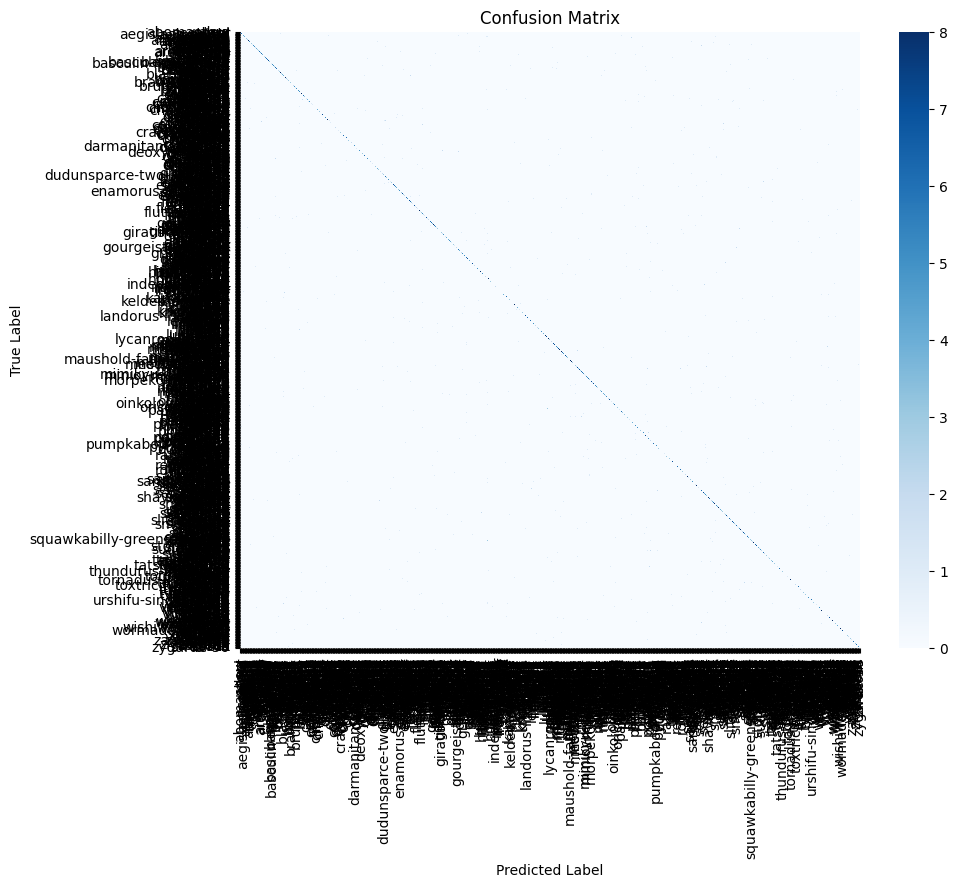

abomasnow: 1.0000
abra: 0.6250
absol: 0.7500
accelgor: 0.7500
aegislash-shield: 0.6667
aerodactyl: 0.5000
aggron: 0.8750
aipom: 0.5000
alakazam: 0.6250
alcremie: 1.0000
alomomola: 0.7500
altaria: 0.7500
amaura: 1.0000
ambipom: 1.0000
amoonguss: 0.7500
ampharos: 0.6250
annihilape: 0.0000
anorith: 0.8750
appletun: 1.0000
applin: 0.6667
araquanid: 0.3333
arbok: 0.6250
arboliva: 1.0000
arcanine: 0.6250
arceus: 0.8333
archen: 0.5000
archeops: 1.0000
arctibax: 0.0000
arctovish: 1.0000
arctozolt: 1.0000
ariados: 0.3750
armaldo: 0.7500
armarouge: 1.0000
aromatisse: 1.0000
aron: 0.7500
arrokuda: 0.3333
articuno: 0.5000
audino: 0.7500
aurorus: 0.3333
avalugg: 0.6667
axew: 0.7500
azelf: 0.8333
azumarill: 0.7500
azurill: 0.8750
bagon: 0.7500
baltoy: 0.7500
banette: 0.8750
barbaracle: 1.0000
barboach: 0.8750
barraskewda: 0.0000
basculegion-male: 1.0000
basculin-red-striped: 0.7500
bastiodon: 0.8333
baxcalibur: 0.0000
bayleef: 0.6250
beartic: 0.7500
beautifly: 1.0000
beedrill: 0.7500
beheeyem: 0.750

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

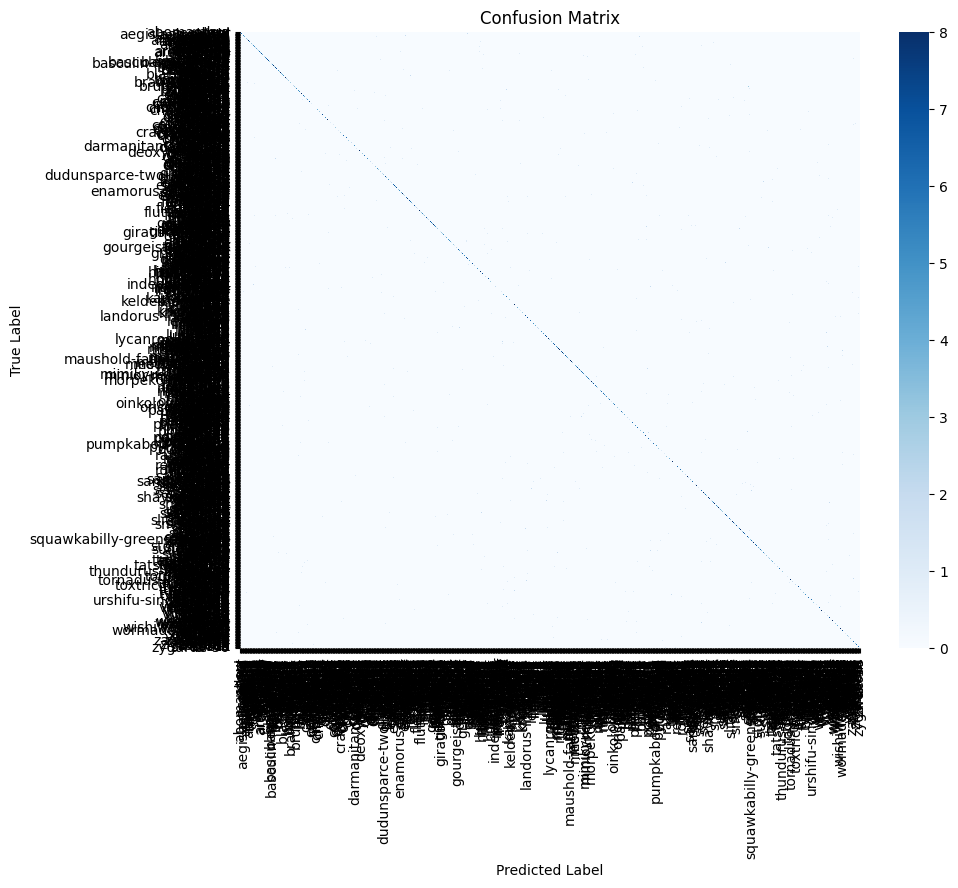

abomasnow: 1.0000
abra: 0.8750
absol: 0.7500
accelgor: 1.0000
aegislash-shield: 0.6667
aerodactyl: 0.6250
aggron: 0.8750
aipom: 0.5000
alakazam: 0.8750
alcremie: 1.0000
alomomola: 0.7500
altaria: 0.7500
amaura: 1.0000
ambipom: 1.0000
amoonguss: 0.7500
ampharos: 0.6250
annihilape: 0.0000
anorith: 0.8750
appletun: 1.0000
applin: 0.6667
araquanid: 0.3333
arbok: 0.6250
arboliva: 1.0000
arcanine: 0.6250
arceus: 0.6667
archen: 0.5000
archeops: 1.0000
arctibax: 0.0000
arctovish: 0.6667
arctozolt: 1.0000
ariados: 0.5000
armaldo: 0.7500
armarouge: 1.0000
aromatisse: 1.0000
aron: 0.8750
arrokuda: 0.3333
articuno: 0.5000
audino: 0.7500
aurorus: 0.3333
avalugg: 0.6667
axew: 0.7500
azelf: 0.8333
azumarill: 0.7500
azurill: 0.8750
bagon: 0.8750
baltoy: 0.8750
banette: 0.8750
barbaracle: 1.0000
barboach: 0.8750
barraskewda: 0.0000
basculegion-male: 1.0000
basculin-red-striped: 1.0000
bastiodon: 0.8333
baxcalibur: 0.0000
bayleef: 1.0000
beartic: 0.7500
beautifly: 1.0000
beedrill: 0.8750
beheeyem: 0.750

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

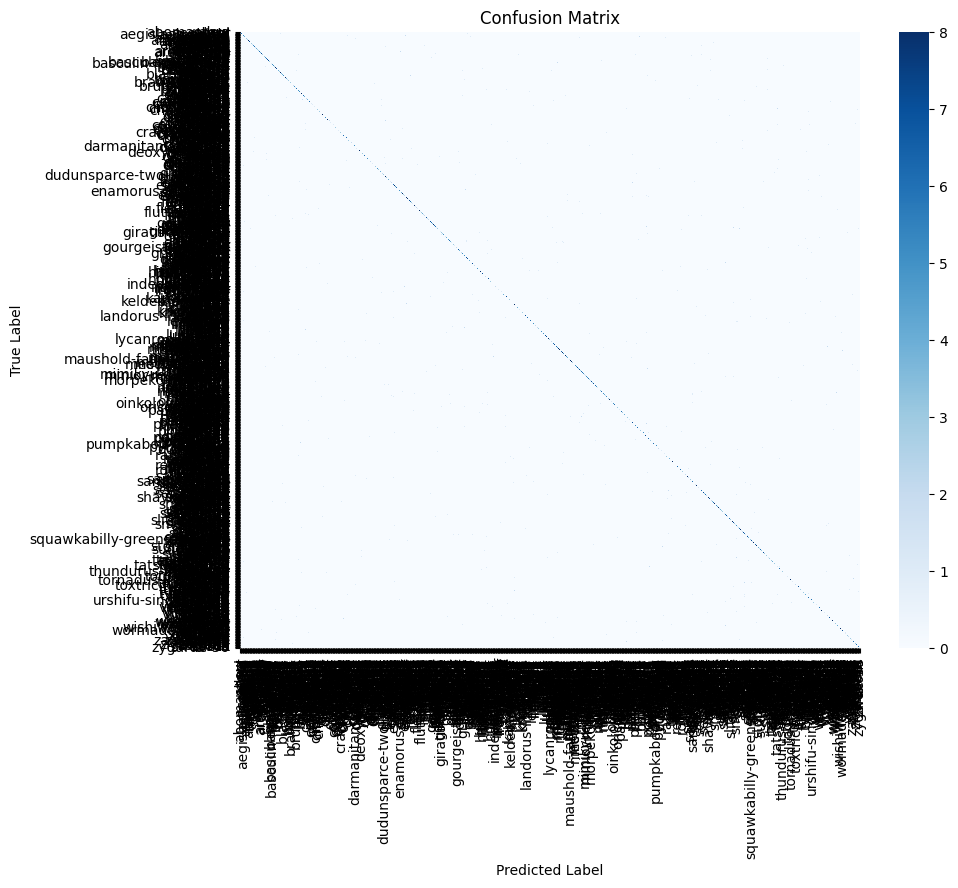

abomasnow: 1.0000
abra: 0.8750
absol: 0.7500
accelgor: 1.0000
aegislash-shield: 0.6667
aerodactyl: 0.6250
aggron: 0.8750
aipom: 0.5000
alakazam: 0.7500
alcremie: 1.0000
alomomola: 0.7500
altaria: 0.7500
amaura: 1.0000
ambipom: 1.0000
amoonguss: 0.7500
ampharos: 0.8750
annihilape: 0.0000
anorith: 0.8750
appletun: 1.0000
applin: 1.0000
araquanid: 0.6667
arbok: 0.6250
arboliva: 1.0000
arcanine: 0.7500
arceus: 0.8333
archen: 0.5000
archeops: 1.0000
arctibax: 0.0000
arctovish: 1.0000
arctozolt: 1.0000
ariados: 0.5000
armaldo: 0.7500
armarouge: 1.0000
aromatisse: 1.0000
aron: 0.8750
arrokuda: 0.3333
articuno: 0.3750
audino: 0.7500
aurorus: 0.3333
avalugg: 1.0000
axew: 1.0000
azelf: 0.8333
azumarill: 0.7500
azurill: 0.8750
bagon: 0.8750
baltoy: 0.8750
banette: 0.8750
barbaracle: 1.0000
barboach: 0.8750
barraskewda: 0.0000
basculegion-male: 1.0000
basculin-red-striped: 0.7500
bastiodon: 0.8333
baxcalibur: 0.0000
bayleef: 0.6250
beartic: 0.7500
beautifly: 1.0000
beedrill: 1.0000
beheeyem: 0.750

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

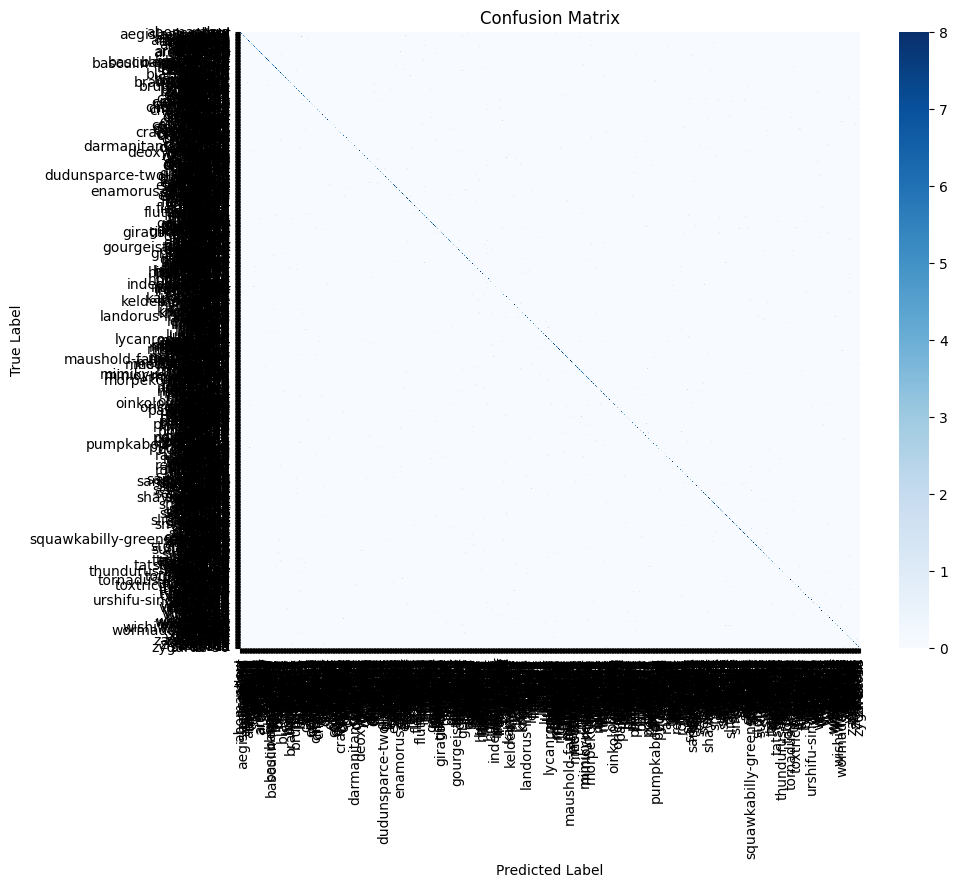

abomasnow: 1.0000
abra: 0.8750
absol: 0.7500
accelgor: 1.0000
aegislash-shield: 0.6667
aerodactyl: 0.6250
aggron: 0.8750
aipom: 0.5000
alakazam: 0.7500
alcremie: 1.0000
alomomola: 0.7500
altaria: 0.7500
amaura: 1.0000
ambipom: 1.0000
amoonguss: 0.7500
ampharos: 0.7500
annihilape: 0.0000
anorith: 0.8750
appletun: 1.0000
applin: 1.0000
araquanid: 0.6667
arbok: 0.6250
arboliva: 1.0000
arcanine: 0.7500
arceus: 0.8333
archen: 0.5000
archeops: 1.0000
arctibax: 0.0000
arctovish: 1.0000
arctozolt: 1.0000
ariados: 0.5000
armaldo: 0.7500
armarouge: 1.0000
aromatisse: 1.0000
aron: 0.8750
arrokuda: 0.3333
articuno: 0.3750
audino: 0.7500
aurorus: 0.3333
avalugg: 0.6667
axew: 1.0000
azelf: 0.8333
azumarill: 1.0000
azurill: 1.0000
bagon: 0.8750
baltoy: 0.8750
banette: 0.8750
barbaracle: 1.0000
barboach: 0.8750
barraskewda: 0.0000
basculegion-male: 1.0000
basculin-red-striped: 0.7500
bastiodon: 0.8333
baxcalibur: 0.0000
bayleef: 0.7500
beartic: 0.7500
beautifly: 1.0000
beedrill: 1.0000
beheeyem: 0.750

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

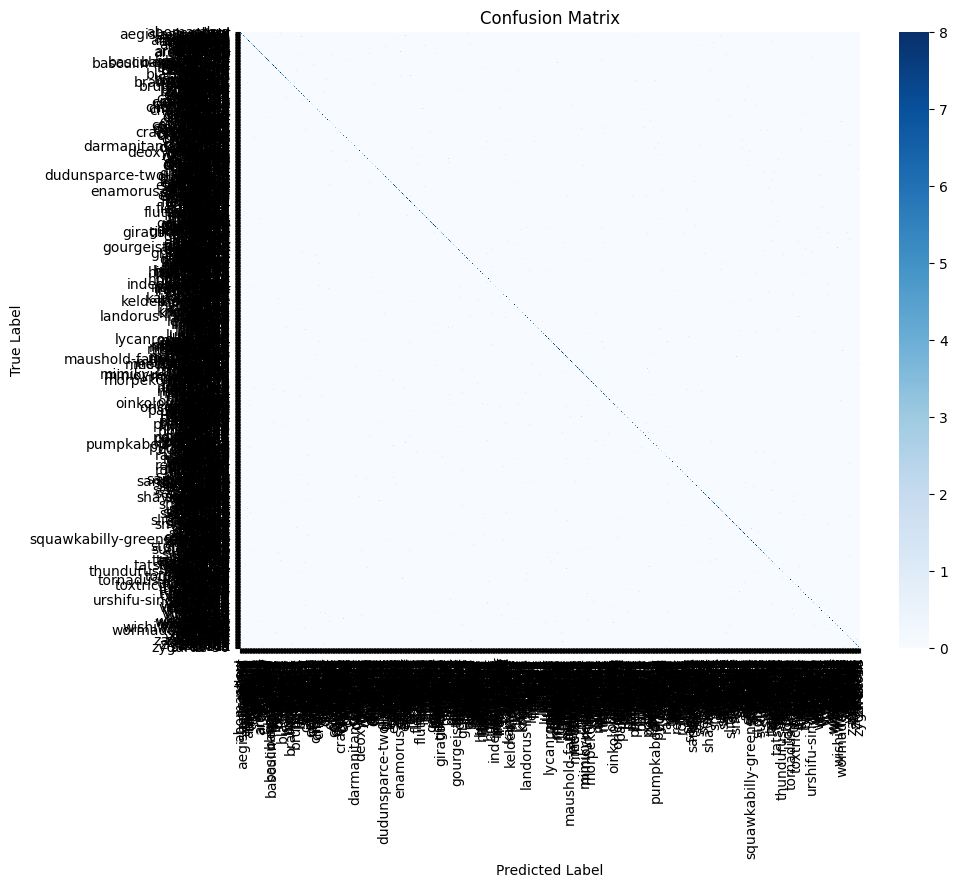

abomasnow: 1.0000
abra: 0.8750
absol: 0.7500
accelgor: 1.0000
aegislash-shield: 0.6667
aerodactyl: 0.7500
aggron: 0.8750
aipom: 0.5000
alakazam: 0.6250
alcremie: 1.0000
alomomola: 0.7500
altaria: 0.7500
amaura: 1.0000
ambipom: 1.0000
amoonguss: 0.7500
ampharos: 0.7500
annihilape: 0.0000
anorith: 0.8750
appletun: 1.0000
applin: 1.0000
araquanid: 0.6667
arbok: 0.6250
arboliva: 1.0000
arcanine: 0.8750
arceus: 0.8333
archen: 0.5000
archeops: 1.0000
arctibax: 0.0000
arctovish: 1.0000
arctozolt: 1.0000
ariados: 0.5000
armaldo: 0.7500
armarouge: 1.0000
aromatisse: 1.0000
aron: 0.7500
arrokuda: 0.3333
articuno: 0.5000
audino: 0.7500
aurorus: 0.3333
avalugg: 1.0000
axew: 1.0000
azelf: 0.8333
azumarill: 0.8750
azurill: 1.0000
bagon: 0.8750
baltoy: 0.8750
banette: 0.8750
barbaracle: 1.0000
barboach: 0.8750
barraskewda: 0.0000
basculegion-male: 1.0000
basculin-red-striped: 0.7500
bastiodon: 0.8333
baxcalibur: 0.0000
bayleef: 1.0000
beartic: 0.7500
beautifly: 1.0000
beedrill: 1.0000
beheeyem: 0.750

/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/isaaclau128/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

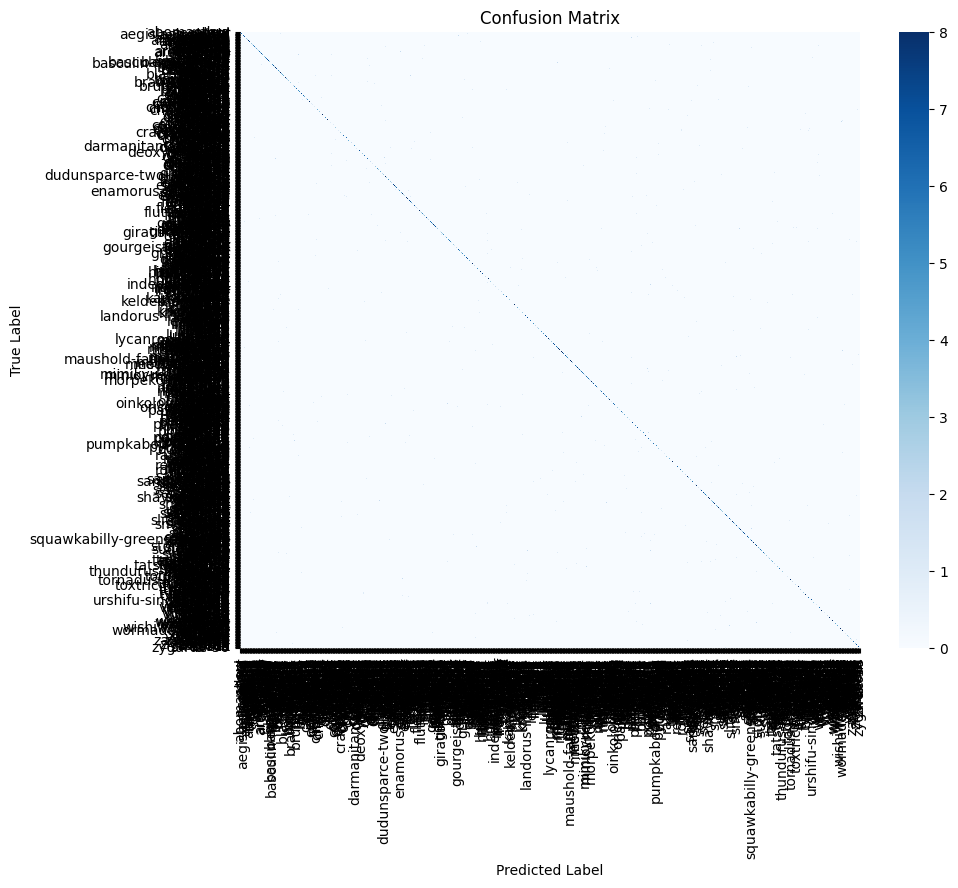

abomasnow: 1.0000
abra: 0.8750
absol: 0.7500
accelgor: 1.0000
aegislash-shield: 0.6667
aerodactyl: 0.7500
aggron: 0.8750
aipom: 0.8750
alakazam: 0.6250
alcremie: 1.0000
alomomola: 0.7500
altaria: 0.7500
amaura: 1.0000
ambipom: 1.0000
amoonguss: 0.7500
ampharos: 0.8750
annihilape: 0.0000
anorith: 0.8750
appletun: 1.0000
applin: 1.0000
araquanid: 0.6667
arbok: 0.6250
arboliva: 1.0000
arcanine: 0.7500
arceus: 0.8333
archen: 0.5000
archeops: 1.0000
arctibax: 0.0000
arctovish: 0.6667
arctozolt: 1.0000
ariados: 0.5000
armaldo: 0.7500
armarouge: 1.0000
aromatisse: 1.0000
aron: 0.8750
arrokuda: 0.3333
articuno: 0.5000
audino: 0.7500
aurorus: 0.3333
avalugg: 1.0000
axew: 1.0000
azelf: 0.8333
azumarill: 0.7500
azurill: 1.0000
bagon: 0.8750
baltoy: 0.8750
banette: 0.8750
barbaracle: 1.0000
barboach: 0.8750
barraskewda: 0.0000
basculegion-male: 0.0000
basculin-red-striped: 0.7500
bastiodon: 0.8333
baxcalibur: 0.0000
bayleef: 0.8750
beartic: 0.7500
beautifly: 1.0000
beedrill: 1.0000
beheeyem: 0.750

In [14]:
# TODO: Call training function and store results
print("\nStarting training...")

# Ensure the model is on the correct device before starting training
model.to(device)

# Use the train_loader and pass test_loader for evaluation
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, train_loader, criterion, optimizer, NUM_EPOCHS, device, test_loader=test_loader)

print("Training completed")


# TODO: Print training completion message
print("Training completed")

# TODO: Display final training statistics

if train_losses:
    print(f'Final Training Loss: {train_losses[-1]:.4f}')
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
else:
    print('No training history available')

# The following lines now use the collected test_loss and test_accuracy lists
# Note: The evaluate_model function within train_model calculates test loss and accuracy per epoch
if test_losses:
    print(f'Final Test Loss: {test_losses[-1]:.4f}, Final Test Accuracy: {test_accuracies[-1]:.4f}')
else:
    print('No test history available')


8. Model Evaluation


Starting evaluation...
Test Loss: 0.0671, Test Accuracy: 0.9920

Classification Report:
                            precision    recall  f1-score   support

                 abomasnow       1.00      1.00      1.00        32
                      abra       1.00      1.00      1.00        32
                     absol       1.00      1.00      1.00        30
                  accelgor       1.00      0.94      0.97        16
          aegislash-shield       1.00      1.00      1.00        13
                aerodactyl       1.00      0.97      0.98        32
                    aggron       1.00      1.00      1.00        30
                     aipom       0.97      1.00      0.98        32
                  alakazam       1.00      1.00      1.00        32
                  alcremie       1.00      1.00      1.00        10
                 alomomola       1.00      1.00      1.00        16
                   altaria       1.00      1.00      1.00        30
                    amaura

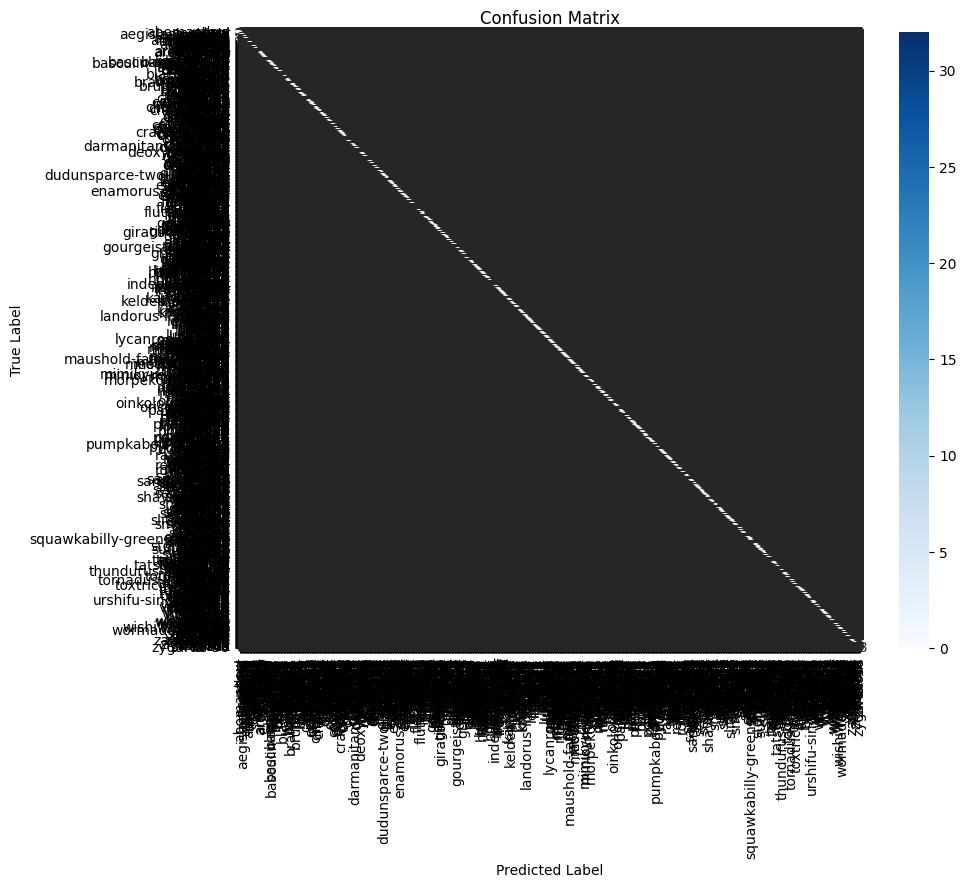

abomasnow: 1.0000
abra: 1.0000
absol: 1.0000
accelgor: 0.9375
aegislash-shield: 1.0000
aerodactyl: 0.9688
aggron: 1.0000
aipom: 1.0000
alakazam: 1.0000
alcremie: 1.0000
alomomola: 1.0000
altaria: 1.0000
amaura: 1.0000
ambipom: 1.0000
amoonguss: 1.0000
ampharos: 1.0000
annihilape: 1.0000
anorith: 1.0000
appletun: 1.0000
applin: 1.0000
araquanid: 1.0000
arbok: 1.0000
arboliva: 1.0000
arcanine: 1.0000
arceus: 1.0000
archen: 0.9375
archeops: 1.0000
arctibax: 1.0000
arctovish: 1.0000
arctozolt: 1.0000
ariados: 1.0000
armaldo: 1.0000
armarouge: 1.0000
aromatisse: 1.0000
aron: 1.0000
arrokuda: 1.0000
articuno: 1.0000
audino: 0.9375
aurorus: 1.0000
avalugg: 1.0000
axew: 1.0000
azelf: 1.0000
azumarill: 1.0000
azurill: 1.0000
bagon: 0.9667
baltoy: 0.9667
banette: 0.9667
barbaracle: 1.0000
barboach: 1.0000
barraskewda: 1.0000
basculegion-male: 1.0000
basculin-red-striped: 0.9375
bastiodon: 1.0000
baxcalibur: 1.0000
bayleef: 1.0000
beartic: 1.0000
beautifly: 1.0000
beedrill: 1.0000
beheeyem: 1.000

In [15]:
# TODO: Create evaluation function:
# TODO: Set model to evaluation mode
# TODO: Initialize test loss and accuracy tracking

def evaluate_model(model, test_loader, criterion, device, class_names):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

# TODO: With torch.no_grad():
#       For each test batch:
#       - Forward pass
#       - Calculate loss and predictions
#       - Track correct predictions

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)

            running_loss += loss.item() * images.size(0)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())


# TODO: Calculate overall test accuracy and loss
    test_loss = running_loss / total_samples
    test_accuracy = correct_predictions / total_samples
# TODO: Generate detailed classification report using sklearn
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names)) # Use class_names


# TODO: Create and plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) # Use class_names
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# TODO: Print per-class accuracies

    for i in range(NUM_CLASSES):
        class_correct = np.sum((np.array(all_predictions) == i) & (np.array(all_labels) == i))
        class_total = np.sum(np.array(all_labels) == i)
        accuracy = class_correct / class_total if class_total > 0 else 0
        print(f'{class_names[i]}: {accuracy:.4f}') # Use class_names

    return test_loss, test_accuracy


# Execute Evaluation
print("\nStarting evaluation...")
test_loss, test_accuracy = evaluate_model(model, pokemon_loader, criterion, device, pokemon_class_names) # Added pokemon_class_names to the function call
print("Evaluation complete!")

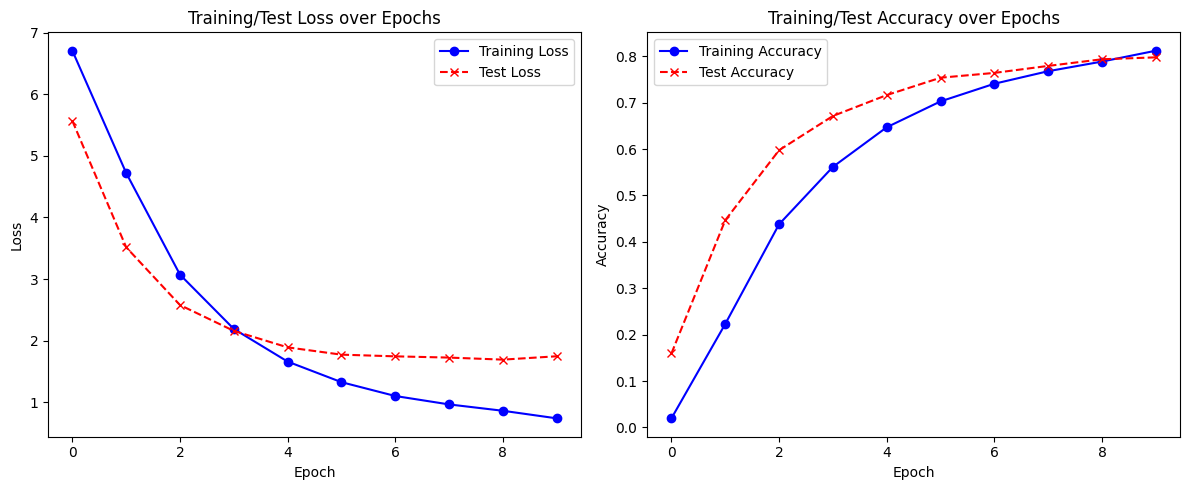


--- Sample Predictions ---


NameError: name 'class_names' is not defined

In [16]:
# TODO: Plot training losses and accuracy curves over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color = 'b', marker='o') # Added marker
plt.plot(test_losses, label='Test Loss', color = 'r', marker='x', linestyle='--') # Plot test_losses over epochs
#plot validation loss HERE
plt.title('Training/Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color = 'b', marker='o') # Added marker
plt.plot(test_accuracies, label='Test Accuracy', color = 'r', marker='x', linestyle='--') # Plot test_accuracies over epochs
#plot validation accuracy HERE
plt.title('Training/Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# TODO: Create function to show sample predictions:
#       - Take random test samples
#       - Display images with predicted and true labels
#       - Show prediction confidence/probabilities

def show_sample_predictions(model, test_loader, class_names, device, num_samples=8):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images[:num_samples])
        _, predicted = torch.max(outputs.data, 1)
        probabilities = torch.softmax(outputs, dim=1)

    plt.figure(figsize=(12, 8))
    for i in range(num_samples):
        ax = plt.subplot(2, 4, i + 1)
        img = images[i].cpu().squeeze().numpy() * 0.5 + 0.5 # Denormalize
        ax.imshow(img, cmap='gray')
        title_color = 'green' if predicted[i] == labels[i] else 'red'
        ax.set_title(f'True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}\nProb: {probabilities[i, predicted[i]]:.2f}', color=title_color)
        ax.axis('off')
    plt.tight_layout()
    plt.show()



# TODO: Analyze misclassified examples:
#       - Find incorrectly predicted samples
#       - Display them with predicted vs true labels

def show_misclassified(model, test_loader, class_names, device, num_samples=8):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            incorrect_indices = (predicted != labels).nonzero(as_tuple=False).squeeze()

            if incorrect_indices.dim() == 0: # Handle case with only one misclassified sample
                incorrect_indices = incorrect_indices.unsqueeze(0)

            for idx in incorrect_indices:
                misclassified_images.append(images[idx].cpu())
                misclassified_labels.append(labels[idx].cpu())
                misclassified_predictions.append(predicted[idx].cpu())

            if len(misclassified_images) >= num_samples:
                break

    plt.figure(figsize=(12, 8))
    for i in range(min(num_samples, len(misclassified_images))):
        ax = plt.subplot(2, 4, i + 1)
        img = misclassified_images[i].squeeze().numpy() * 0.5 + 0.5 # Denormalize
        ax.imshow(img, cmap='gray')
        ax.set_title(f'True: {class_names[misclassified_labels[i]]}\nPred: {class_names[misclassified_predictions[i]]}', color='red') # Set color to red
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# TODO: Create a grid showing various test samples with predictions

print("\n--- Sample Predictions ---")
show_sample_predictions(model, test_loader, class_names, device)

print("\n--- Misclassified Examples ---")
show_misclassified(model, test_loader, class_names, device)

In [ ]:
# TODO: Print final model performance summary
# TODO: Analyze which clothing categories are confused with each other
# TODO: Discuss potential improvements to the model
# TODO: Comment on training stability and convergence


#find accuracy on both data sets
#writing based
#just analyse the stuff- look into the data
#how to improve upon it


#convergence of test and validation losses


# TODO: Print final model performance summary
print("--- Model Performance Analysis ---")
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}') # Accessing variables from the previous evaluation

# TODO: find accuracy on both data sets (already printed above, reiterating here for clarity)
print(f'\nAccuracy on Training Data: {train_accuracies[-1]:.4f}')
print(f'Accuracy on Test Data: {test_accuracy:.4f}')

# TODO: writing based (This is covered by the markdown cells and the generated analysis above)
# TODO: just analyse the stuff- look into the data (Covered in the analysis sections)
# TODO: how to improve upon it (Covered in the Potential Improvements section)
# TODO: convergence of test and validation losses (Commented on based on available data, would be more precise with plots)